In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
#https://medium.com/towards-artificial-intelligence/recommendation-system-in-depth-tutorial-with-python-for-netflix-using-collaborative-filtering-533ff8a0e444

In [2]:
def load_data():
    netflix_csv_file = open("netflix_rating.csv", mode = "w")
    rating_files = ['combined_data_4.txt'] 
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movie_id = line.replace(":", "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(",".join(row_data))  
                    netflix_csv_file.write('\n')
                    
    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

In [3]:
netflix_rating_df = load_data()
netflix_rating_df.head()

,movie_id,customer_id,rating,date
0,13368,2385003,4,2004-07-08
1,13368,659432,3,2005-03-16
2,13368,751812,2,2002-12-16
3,13368,2625420,2,2004-05-25
4,13368,1650301,1,2005-08-30


In [4]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

In [41]:
train_data,test_data = train_test_split(netflix_rating_df,random_state=3,test_size=0.2)
train_data.shape,test_data.shape

((21478018, 4), (5369505, 4))

<ipython-input-6-619411535455>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


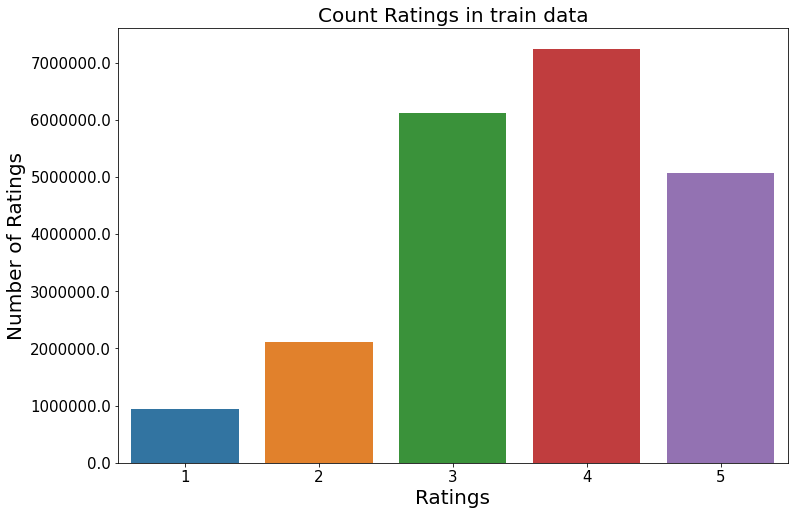

In [6]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show();

In [7]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

In [8]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [9]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [10]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print(f"Global Average Rating: {round(global_average_rating,3)}")

Global Average Rating: 3.623


In [11]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [12]:
average_rating_user = get_average_rating(train_sparse_data, True)

In [13]:
avg_rating_movie = get_average_rating(train_sparse_data, False)

In [14]:
total_users = len(np.unique(netflix_rating_df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print(f"Total no. of Users = {total_users}")
print(f"No. of Users in train data= {train_users}")
print(f"No. of Users not present in train data = {uncommonUsers} ({np.round((uncommonUsers/total_users)*100, 2)}%)")

Total no. of Users = 475601
No. of Users in train data= 473732
No. of Users not present in train data = 1869 (0.39%)


In [15]:
total_movies = len(np.unique(netflix_rating_df["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print(f"Total no. of Movies = {total_movies}")
print(f"No. of Movies in train data= {train_movies}")
print(f"No. of Movies not present in train data = {uncommonMovies}({np.round((uncommonMovies/total_movies*100), 2)}%)")

Total no. of Movies = 4403
No. of Movies in train data= 4403
No. of Movies not present in train data = 0(0.0%)


In [16]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [17]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [18]:
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
movie_titles_df = pd.read_csv("movie_titles.csv",sep = ",",
                              header = None, names=['movie_id', 'year_of_release', 'movie_title'],
                              index_col = "movie_id", encoding = "iso8859_2")
movie_titles_df.head()

,year_of_release,movie_title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [20]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [21]:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1775)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Dario Argento Collection: Vol. 1: Phenomena', 0)


In [22]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

In [23]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

In [24]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

In [25]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df

In [26]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [27]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,62753,14219,3.470149,3,4.0,5.0,1.0,4.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.5,3.0
1,978348,14219,3.470149,3,4.0,5.0,1.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.5,4.0
2,1064369,14219,3.470149,3,4.0,4.0,4.0,1.0,4.0,2.0,3.666667,3.666667,3.666667,3.666667,3.5,5.0
3,1440344,14219,3.470149,3,4.0,5.0,1.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.5,4.0
4,2124531,14219,3.470149,4,4.0,3.0,5.0,4.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,3.5,1.0


In [28]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [29]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,226007,13580,3.222222,5,3.0,2.0,4.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,3.333333,1.0
1,273576,13580,3.222222,3,2.0,4.0,5.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,3.333333,4.0
2,283134,13580,3.222222,3,2.0,4.0,5.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.333333,3.0
3,848872,13580,3.222222,3,2.0,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,3.333333,5.0
4,1988038,13580,3.222222,3,2.0,4.0,5.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.333333,2.0


In [30]:
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [31]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [32]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[21:53:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=10, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [33]:
y_pred_test = clf.predict(x_test)

In [34]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.5031351300314933


In [35]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

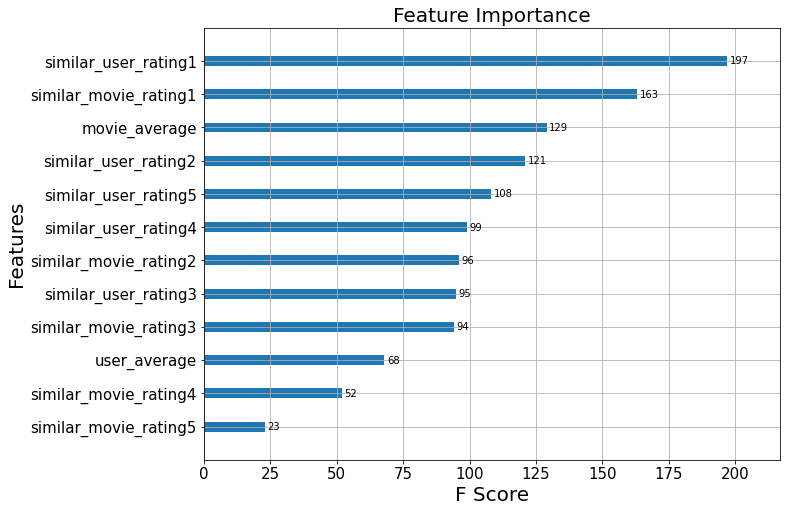

In [36]:
plot_importance(xgb, clf)